# Unsupervised

Epoch 1/5
627/627 - 5s - 8ms/step - loss: 0.0196 - val_loss: 5.1711e-04
Epoch 2/5
627/627 - 4s - 6ms/step - loss: 4.7361e-04 - val_loss: 1.4771e-04
Epoch 3/5
627/627 - 4s - 6ms/step - loss: 2.4068e-04 - val_loss: 1.3781e-04
Epoch 4/5
627/627 - 4s - 6ms/step - loss: 2.4087e-04 - val_loss: 1.1860e-04
Epoch 5/5
627/627 - 4s - 6ms/step - loss: 1.7472e-04 - val_loss: 1.1581e-04
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step


/var/folders/d1/7_phhjrs5yzbb3xycn7mr4th0000gn/T/ipykernel_5506/576520624.py:115: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[threshold], colors='black', linewidths=2, linestyles='--', label='95% Control Limit')


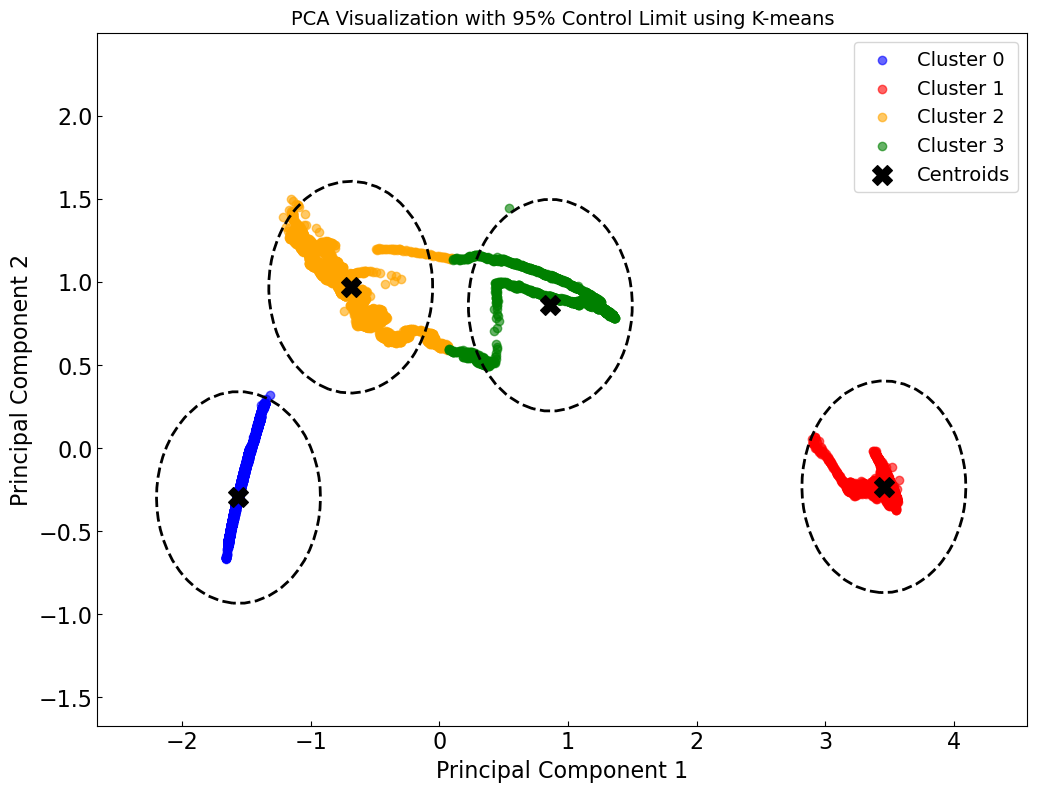

K-means distance threshold for 95% control limit: 0.6374980688095092


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Build the LSTM autoencoder model
input_seq = Input(shape=(seq_length, X_train.shape[2]))
encoded = LSTM(50, activation='tanh', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(50, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Encoder model to extract latent representations
encoder = Model(input_seq, encoded)

# Extract latent representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Flatten the sequences for PCA and K-means fitting
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# Apply PCA for 2D Visualization and get principal component scores
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_encoded_flat)
X_test_pca = pca.transform(X_test_encoded_flat)

# Apply K-means clustering on the PCA-transformed training data
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_train_pca)
train_labels = kmeans.predict(X_train_pca)
centroids = kmeans.cluster_centers_

# Calculate distances of each point to its assigned centroid
distances = np.linalg.norm(X_train_pca - centroids[train_labels], axis=1)

# Set the 95% control limit threshold based on the 95th percentile of distances
threshold = np.percentile(distances, 98)

# Plot PCA data with 95% control limit based on K-means distances
plt.figure(figsize=(12, 9))

# Define colors for each cluster
colors = ['blue', 'red', 'orange', 'green']  # Adjust the colors as per your preference

# Scatter plot of the PCA-transformed data with specified colors
for i in range(kmeans.n_clusters):
    plt.scatter(X_train_pca[train_labels == i, 0], X_train_pca[train_labels == i, 1], 
                color=colors[i], label=f'Cluster {i}', alpha=0.6)


# Plot the K-means centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='X', label='Centroids')

# Define a grid for contour plotting
x_values = np.linspace(min(X_train_pca[:, 0]) - 2, max(X_train_pca[:, 0]) + 2, 100)  # Increase range
y_values = np.linspace(min(X_train_pca[:, 1]) - 2, max(X_train_pca[:, 1]) + 2, 100)  # Increase range
X, Y = np.meshgrid(x_values, y_values)
XX = np.array([X.ravel(), Y.ravel()]).T

# Calculate distances of each point in the grid to the closest centroid
Z = np.min([np.linalg.norm(XX - centroid, axis=1) for centroid in centroids], axis=0)
Z = Z.reshape(X.shape)

# Plot the 95% control limit contour
plt.contour(X, Y, Z, levels=[threshold], colors='black', linewidths=2, linestyles='--', label='95% Control Limit')

# Customize plot
plt.title('PCA Visualization with 95% Control Limit using K-means', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=16, direction='in')
plt.xlim(min(X_train_pca[:, 0]) - 1, max(X_train_pca[:, 0]) + 1)
plt.ylim(min(X_train_pca[:, 1]) - 1, max(X_train_pca[:, 1]) + 1)
plt.show()

# Print the control limit threshold
print(f'K-means distance threshold for 95% control limit: {threshold}')


Epoch 1/5
627/627 - 8s - 13ms/step - loss: 0.0196 - val_loss: 5.1711e-04
Epoch 2/5
627/627 - 6s - 9ms/step - loss: 4.7361e-04 - val_loss: 1.4771e-04
Epoch 3/5
627/627 - 6s - 9ms/step - loss: 2.4068e-04 - val_loss: 1.3781e-04
Epoch 4/5
627/627 - 6s - 9ms/step - loss: 2.4087e-04 - val_loss: 1.1860e-04
Epoch 5/5
627/627 - 6s - 9ms/step - loss: 1.7472e-04 - val_loss: 1.1581e-04
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


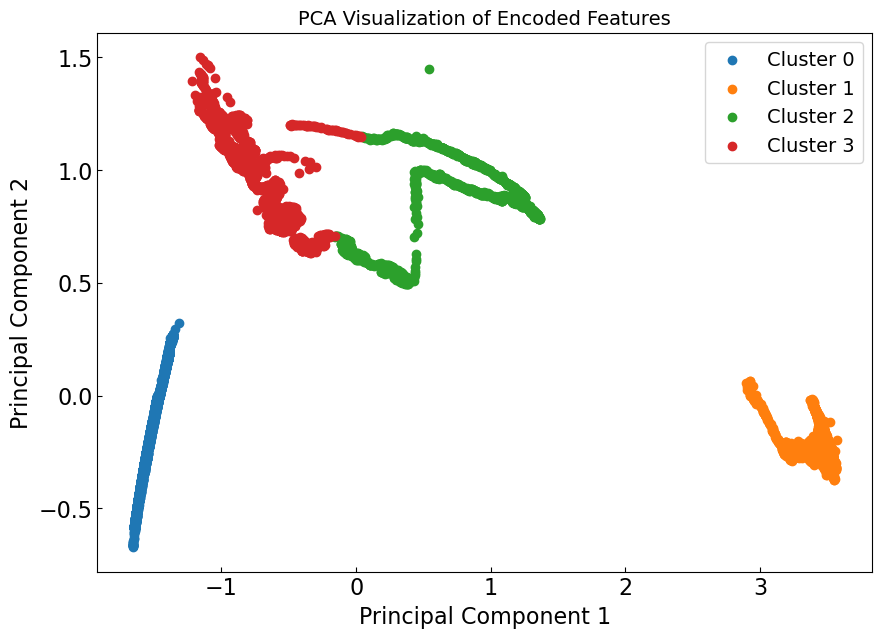

Clustering Test Accuracy: 59.82%
Classification Report for LSTM Autoencoder with Clustering:
              precision    recall  f1-score   support

     Crevice       0.40      1.00      0.57      1303
     General       1.00      1.00      1.00      1529
     Passive       0.00      0.00      0.00      1972
     Pitting       1.00      0.63      0.77      1467

    accuracy                           0.60      6271
   macro avg       0.60      0.66      0.58      6271
weighted avg       0.56      0.60      0.54      6271



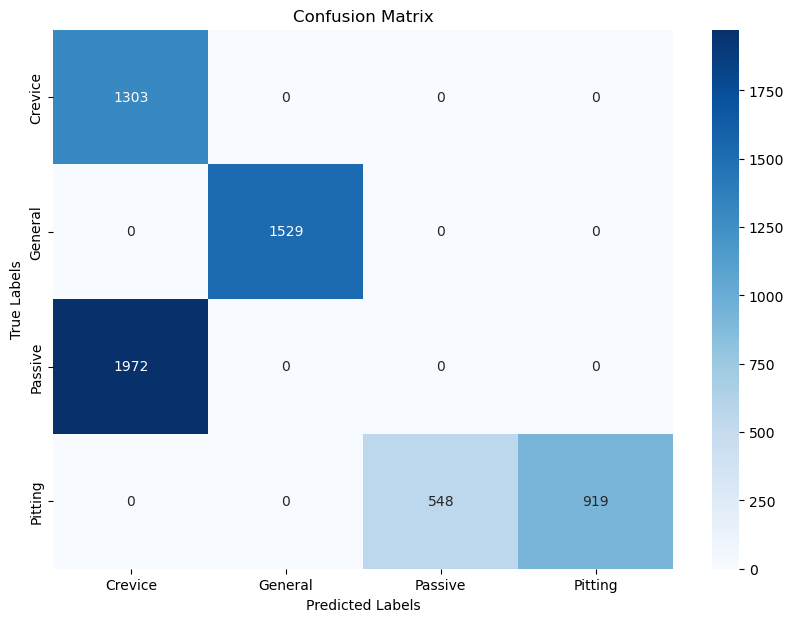

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Build the LSTM autoencoder model
input_seq = Input(shape=(seq_length, X_train.shape[2]))
encoded = LSTM(50, activation='tanh', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(50, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Encoder model to extract latent representations
encoder = Model(input_seq, encoded)

# Extract latent representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Flatten the sequences to fit into the clustering algorithm
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# Apply K-means clustering
n_clusters = len(np.unique(y_encoded))
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_train_encoded_flat)

# Predict the cluster labels
y_train_pred = kmeans.predict(X_train_encoded_flat)
y_test_pred = kmeans.predict(X_test_encoded_flat)

# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_encoded_flat)

plt.figure(figsize=(10, 7))
for i in range(n_clusters):
    plt.scatter(X_pca[y_train_pred == i, 0], X_pca[y_train_pred == i, 1], label=f'Cluster {i}')
plt.title('PCA Visualization of Encoded Features',fontsize=14)
plt.xlabel('Principal Component 1',fontsize=16)
plt.ylabel('Principal Component 2',fontsize=16)
plt.legend(prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=16, direction='in')  
plt.show()

# Evaluate clustering on the test set
accuracy = accuracy_score(y_test, y_test_pred[:len(y_test)])
print(f'Clustering Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for LSTM Autoencoder with Clustering:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Unsupervised larger sequence

Epoch 1/5
18/18 - 19s - 1s/step - loss: 0.3628 - val_loss: 0.0556
Epoch 2/5
18/18 - 8s - 469ms/step - loss: 0.0347 - val_loss: 0.0169
Epoch 3/5
18/18 - 8s - 464ms/step - loss: 0.0110 - val_loss: 0.0070
Epoch 4/5
18/18 - 8s - 470ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 5/5
18/18 - 8s - 467ms/step - loss: 0.0065 - val_loss: 0.0047
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/d1/7_phhjrs5yzbb3xycn7mr4th0000gn/T/ipykernel_5701/584792003.py:111: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[threshold], colors='purple', linewidths=1.5, linestyles='--', label='95% Control Limit')


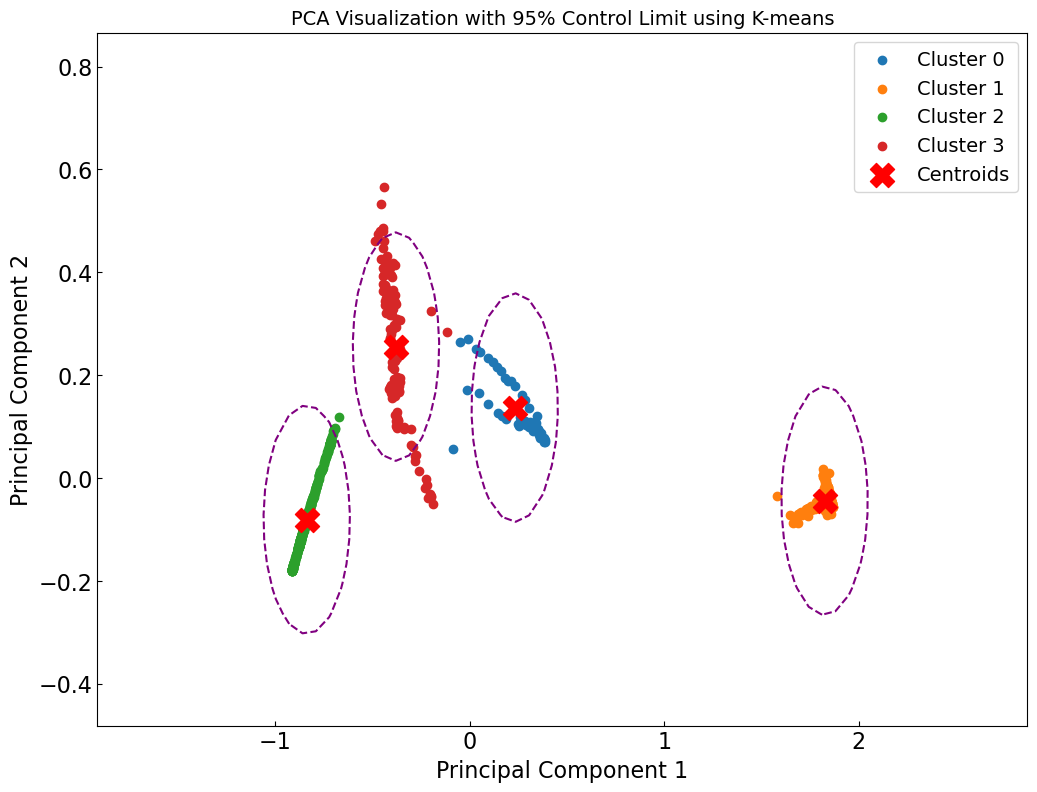

K-means distance threshold for 95% control limit: 0.2222076766192913
Clustering Test Accuracy: 70.39%
Classification Report for LSTM Autoencoder with Clustering:
              precision    recall  f1-score   support

     Crevice       0.00      0.00      0.00        42
     General       1.00      1.00      1.00        35
     Passive       0.60      1.00      0.75        64
     Pitting       1.00      0.71      0.83        38

    accuracy                           0.70       179
   macro avg       0.65      0.68      0.65       179
weighted avg       0.62      0.70      0.64       179



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

seq_length = 700
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Build the LSTM autoencoder model
input_seq = Input(shape=(seq_length, X_train.shape[2]))
encoded = LSTM(50, activation='tanh', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(50, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Encoder model to extract latent representations
encoder = Model(input_seq, encoded)

# Extract latent representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Flatten the sequences for PCA and K-means fitting
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# Apply K-means clustering
n_clusters = len(np.unique(y_encoded))
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_train_encoded_flat)

# Predict the cluster labels for both train and test sets
y_train_pred = kmeans.predict(X_train_encoded_flat)
y_test_pred = kmeans.predict(X_test_encoded_flat)

# Calculate distances of each point to its assigned centroid for the 95% threshold
centroids = kmeans.cluster_centers_
train_distances = np.linalg.norm(X_train_encoded_flat - centroids[y_train_pred], axis=1)
threshold = np.percentile(train_distances, 95)  # 95% control limit threshold

# PCA for 2D visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_encoded_flat)

# Plot the PCA-transformed data and K-means clusters with the 95% threshold
plt.figure(figsize=(12, 9))

# Scatter plot of the PCA-transformed data
for i in range(n_clusters):
    plt.scatter(X_train_pca[y_train_pred == i, 0], X_train_pca[y_train_pred == i, 1], label=f'Cluster {i}')

# Plot the K-means centroids
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='red', marker='X', label='Centroids')

# Define a grid for plotting the 95% threshold contour
x_values = np.linspace(min(X_train_pca[:, 0]) - 2, max(X_train_pca[:, 0]) + 2, 100)
y_values = np.linspace(min(X_train_pca[:, 1]) - 2, max(X_train_pca[:, 1]) + 2, 100)
X, Y = np.meshgrid(x_values, y_values)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.min([np.linalg.norm(XX - centroid, axis=1) for centroid in centroids_pca], axis=0)
Z = Z.reshape(X.shape)

# Plot the 95% control limit contour
plt.contour(X, Y, Z, levels=[threshold], colors='purple', linewidths=1.5, linestyles='--', label='95% Control Limit')

# Customize plot
plt.title('PCA Visualization with 95% Control Limit using K-means', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=16, direction='in')
plt.xlim(min(X_train_pca[:, 0]) - 1, max(X_train_pca[:, 0]) + 1)
plt.ylim(min(X_train_pca[:, 1])-0.3, max(X_train_pca[:, 1])+0.3)
plt.show()

# Print the control limit threshold
print(f'K-means distance threshold for 95% control limit: {threshold}')

# Evaluate clustering on the test set
accuracy = accuracy_score(y_test, y_test_pred[:len(y_test)])
print(f'Clustering Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for LSTM Autoencoder with Clustering:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))




/var/folders/d1/7_phhjrs5yzbb3xycn7mr4th0000gn/T/ipykernel_5701/1431044974.py:27: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[threshold], colors='black', linewidths=2, linestyles='--', label='95% Control Limit')


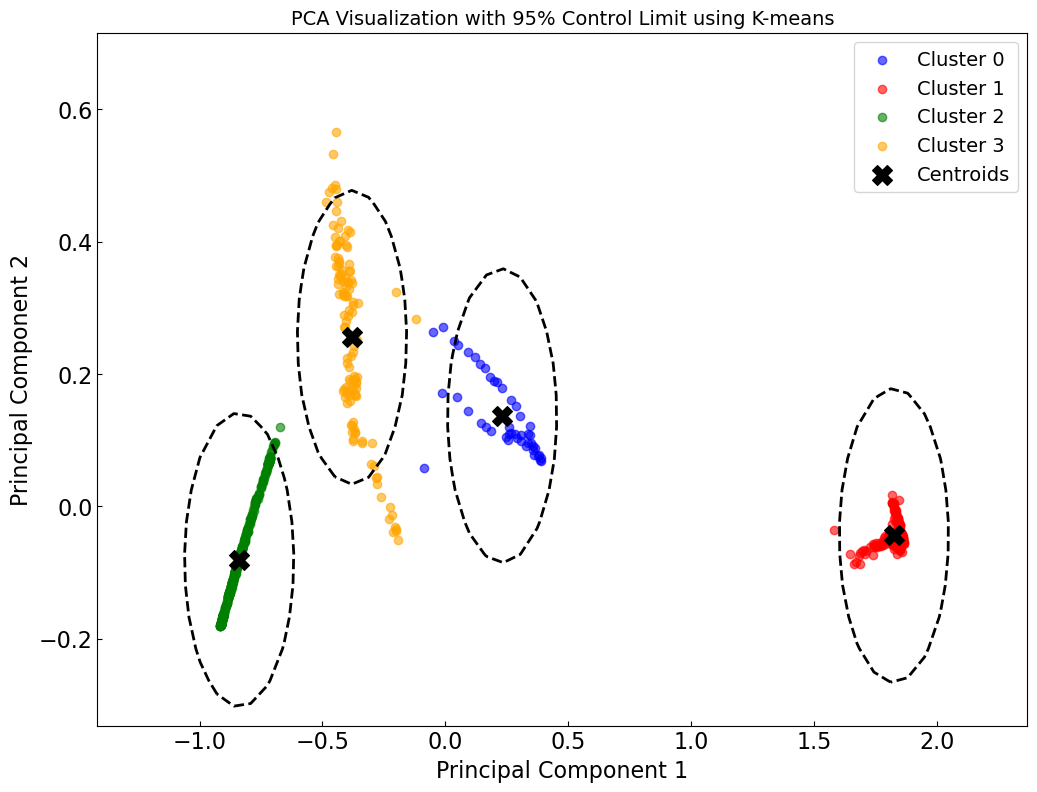

K-means distance threshold for 95% control limit: 0.2222076766192913
Clustering Test Accuracy: 70.39%
Classification Report for LSTM Autoencoder with Clustering:
              precision    recall  f1-score   support

     Crevice       0.00      0.00      0.00        42
     General       1.00      1.00      1.00        35
     Passive       0.60      1.00      0.75        64
     Pitting       1.00      0.71      0.83        38

    accuracy                           0.70       179
   macro avg       0.65      0.68      0.65       179
weighted avg       0.62      0.70      0.64       179



In [3]:

# Plot the PCA-transformed data and K-means clusters with the 95% threshold
plt.figure(figsize=(12, 9))

# Scatter plot of the PCA-transformed data
# Define a list of colors for each cluster
colors = ['blue', 'red', 'green', 'orange']  # Adjust the colors to match your number of clusters

# Scatter plot of the PCA-transformed data with specified colors
for i in range(n_clusters):
    plt.scatter(X_train_pca[y_train_pred == i, 0], X_train_pca[y_train_pred == i, 1], 
                color=colors[i], label=f'Cluster {i}', alpha=0.6)


# Plot the K-means centroids
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='black', marker='X', label='Centroids')

# Define a grid for plotting the 95% threshold contour
x_values = np.linspace(min(X_train_pca[:, 0]) - 2, max(X_train_pca[:, 0]) + 2, 100)
y_values = np.linspace(min(X_train_pca[:, 1]) - 2, max(X_train_pca[:, 1]) + 2, 100)
X, Y = np.meshgrid(x_values, y_values)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.min([np.linalg.norm(XX - centroid, axis=1) for centroid in centroids_pca], axis=0)
Z = Z.reshape(X.shape)

# Plot the 95% control limit contour
plt.contour(X, Y, Z, levels=[threshold], colors='black', linewidths=2, linestyles='--', label='95% Control Limit')

# Customize plot
plt.title('PCA Visualization with 95% Control Limit using K-means', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=16, direction='in')
plt.xlim(min(X_train_pca[:, 0]) - 0.5, max(X_train_pca[:, 0]) + 0.5)
plt.ylim(min(X_train_pca[:, 1])-0.15, max(X_train_pca[:, 1])+0.15)
plt.show()

# Print the control limit threshold
print(f'K-means distance threshold for 95% control limit: {threshold}')

# Evaluate clustering on the test set
accuracy = accuracy_score(y_test, y_test_pred[:len(y_test)])
print(f'Clustering Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for LSTM Autoencoder with Clustering:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Epoch 1/5
18/18 - 29s - 2s/step - loss: 0.3628 - val_loss: 0.0556
Epoch 2/5
18/18 - 12s - 655ms/step - loss: 0.0347 - val_loss: 0.0169
Epoch 3/5
18/18 - 12s - 645ms/step - loss: 0.0110 - val_loss: 0.0070
Epoch 4/5
18/18 - 12s - 643ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 5/5
18/18 - 12s - 647ms/step - loss: 0.0065 - val_loss: 0.0047
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


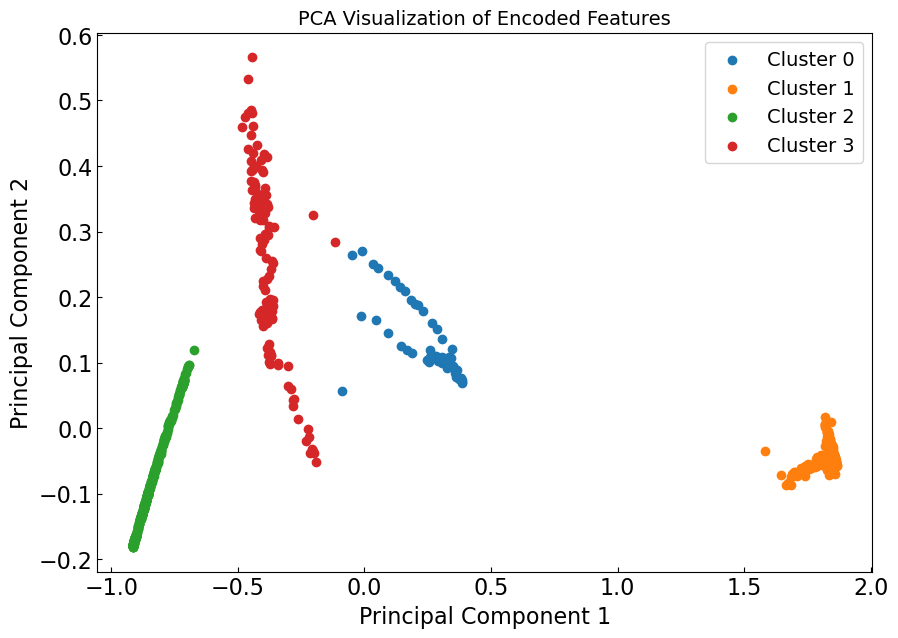

Clustering Test Accuracy: 70.39%
Classification Report for LSTM Autoencoder with Clustering:
              precision    recall  f1-score   support

     Crevice       0.00      0.00      0.00        42
     General       1.00      1.00      1.00        35
     Passive       0.60      1.00      0.75        64
     Pitting       1.00      0.71      0.83        38

    accuracy                           0.70       179
   macro avg       0.65      0.68      0.65       179
weighted avg       0.62      0.70      0.64       179



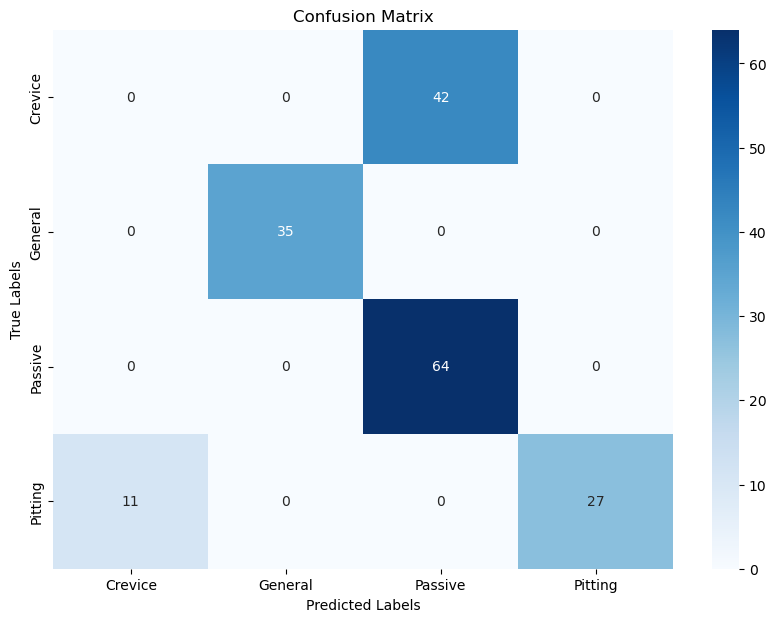

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

seq_length = 700
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Build the LSTM autoencoder model
input_seq = Input(shape=(seq_length, X_train.shape[2]))
encoded = LSTM(50, activation='tanh', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(50, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Encoder model to extract latent representations
encoder = Model(input_seq, encoded)

# Extract latent representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Flatten the sequences to fit into the clustering algorithm
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# Apply K-means clustering
n_clusters = len(np.unique(y_encoded))
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_train_encoded_flat)

# Predict the cluster labels
y_train_pred = kmeans.predict(X_train_encoded_flat)
y_test_pred = kmeans.predict(X_test_encoded_flat)


# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_encoded_flat)
plt.figure(figsize=(10, 7))
for i in range(n_clusters):
    plt.scatter(X_pca[y_train_pred == i, 0], X_pca[y_train_pred == i, 1], label=f'Cluster {i}')
plt.title('PCA Visualization of Encoded Features',fontsize=14)
plt.xlabel('Principal Component 1',fontsize=16)
plt.ylabel('Principal Component 2',fontsize=16)
plt.legend(prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=16, direction='in')  
plt.show()

# Evaluate clustering on the test set
accuracy = accuracy_score(y_test, y_test_pred[:len(y_test)])
print(f'Clustering Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for LSTM Autoencoder with Clustering:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()